# Test U-Net

## Imports

In [3]:
import os
import random

import cv2 as cv
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, callbacks, losses
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

import sys
sys.path.append('code')
from eval_functions import calculate_score
from UNet import jaccard_coef, jaccard_coef_loss
sys.path.append('../')

## Preparing test data

In [4]:
# Finding the number of images in each dataset
test_path = os.path.normpath('dataset/MapAI/512x512_task1_test/image')
no_test_images = len([name for name in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, name))])

# Defining size of images
IMG_HEIGHT = 512
IMG_WIDTH = 512

# Creating NumPy arrays for the different subsets
X_test = np.zeros((no_test_images, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
Y_test = np.zeros((no_test_images, IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

# Defining sets
subsets = ['image', 'mask']

# Adding images to NumPy arrays
for subset in tqdm(subsets):
    subset_path = os.path.normpath('dataset/MapAI/512x512_task1_test/' + subset)
    with os.scandir(subset_path) as entries:
        for n, entry in enumerate(entries):
            img = cv.imread(os.path.normpath(subset_path + '/' + entry.name))
            if subset == 'image':
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                X_test[n] = img
            if subset == 'mask':
                img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
                Y_test[n] = img

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.62s/it]


In [5]:
# Print the size of the different sets
print('X_train size: ' + str(len(X_test)))
print('Y_train size: ' + str(len(Y_test)))

X_train size: 1368
Y_train size: 1368


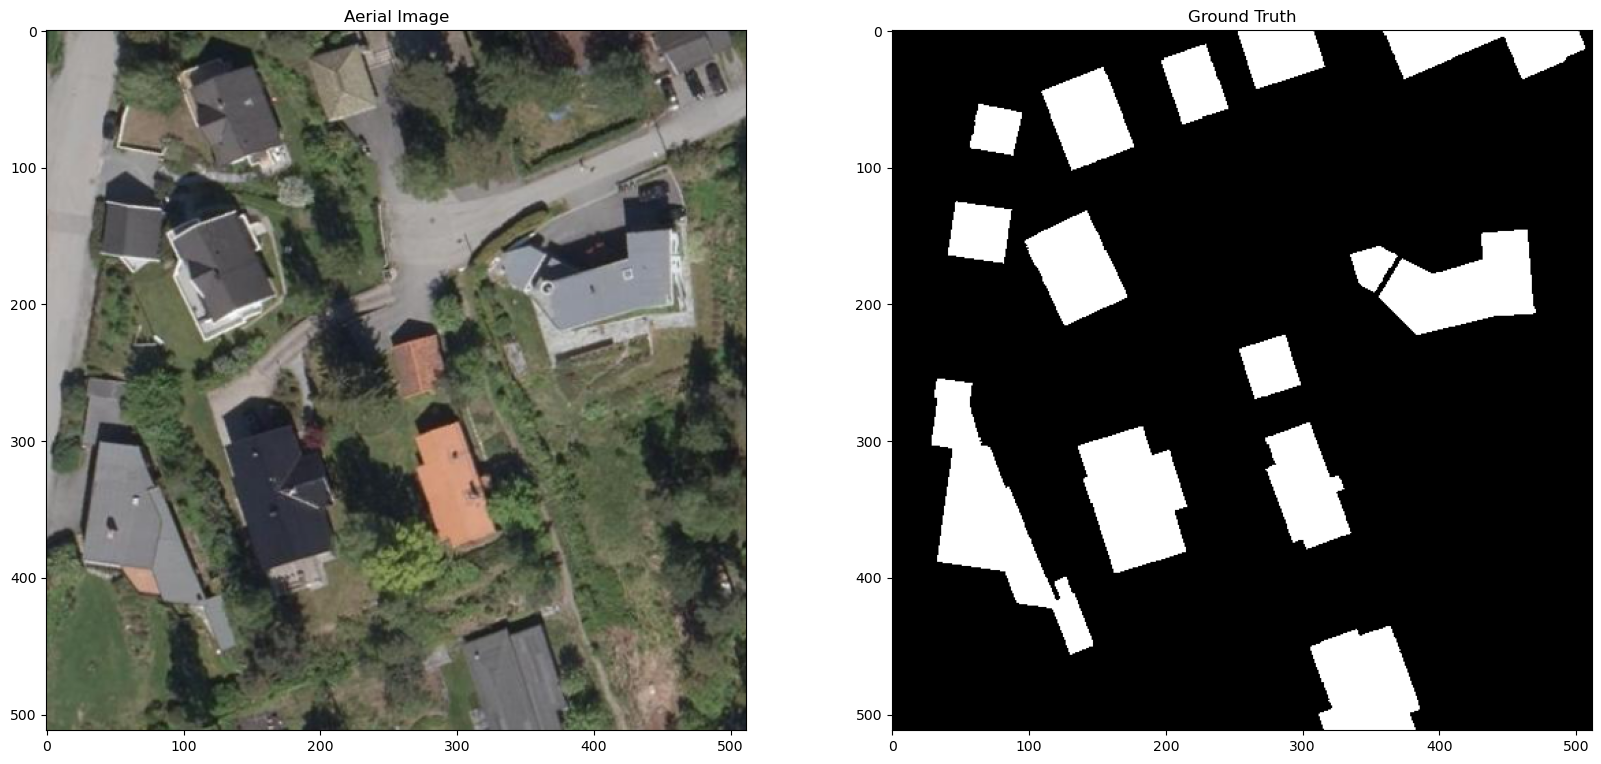

(array([0, 1], dtype=uint8), array([217051,  45093], dtype=int64))


In [6]:
# Display a random image from test set
index = random.randint(0, no_test_images)

plt.figure(figsize=(20,20))
plt.subplot(221)
plt.title('Aerial Image')
plt.imshow(X_test[index])
plt.subplot(222)
plt.title('Ground Truth')
plt.imshow(Y_test[index], cmap='gray')
plt.show()

print(np.unique(Y_test[index], return_counts=True))

## Testing model

In [8]:
# Load model
model = models.load_model(os.path.normpath('models/recentUNet1'), custom_objects={'jaccard_coef': jaccard_coef, 'jaccard_coef_loss': jaccard_coef_loss})

In [9]:
Y_pred = model.predict(X_test[0:10])

1/1 [==============================] - 37s 37s/step


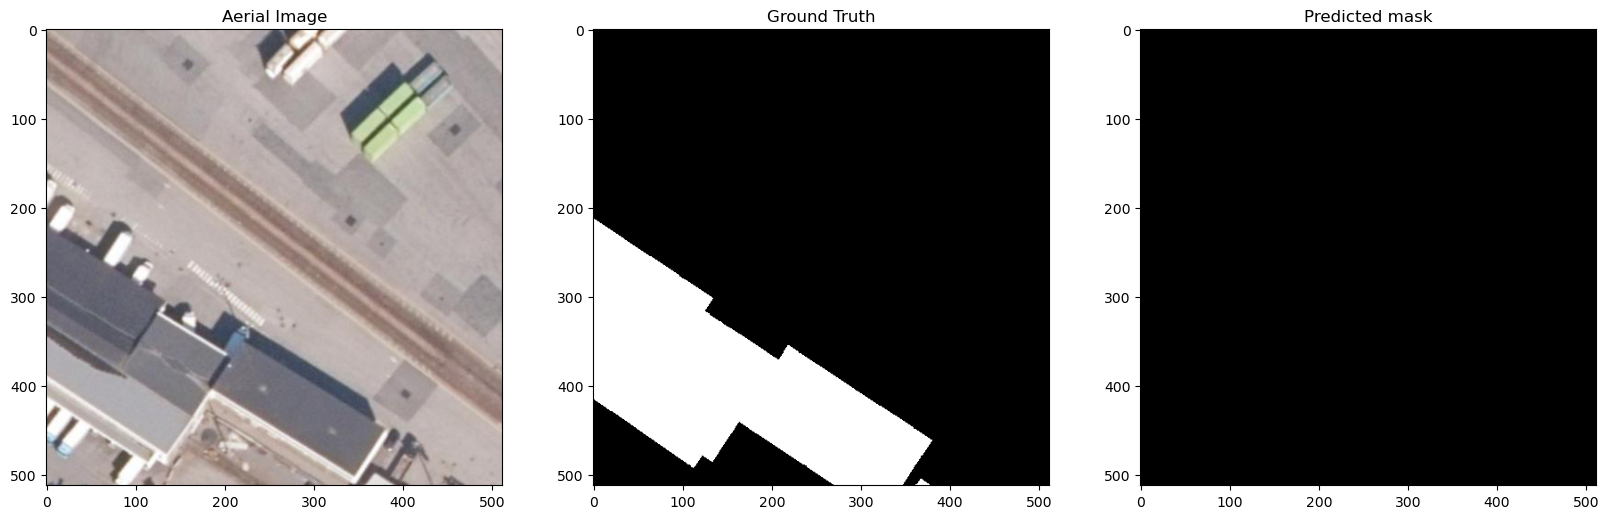

(array([0, 1], dtype=uint8), array([210472,  51672], dtype=int64))
(array([0.], dtype=float32), array([262144], dtype=int64))


In [78]:
# Display predicted image mask
index = 9

plt.figure(figsize=(20,20))
plt.subplot(231)
plt.title('Aerial Image')
plt.imshow(X_test[index])
plt.subplot(232)
plt.title('Ground Truth')
plt.imshow(Y_test[index], cmap='gray')
plt.subplot(233)
plt.title('Predicted mask')
plt.imshow(Y_pred[index], cmap='gray')
plt.show()

print(np.unique(Y_test[index], return_counts=True))
print(np.unique(Y_pred[index], return_counts=True))

## Evaluating model

In [79]:
score = calculate_score(np.squeeze((Y_pred > 0.5), -1).astype(np.uint8), Y_test[0:10])
print(score)

{'score': 0.428388514299043, 'iou': 0.505801773071289, 'biou': 0.350975255526797}
